![](tec.png)


    
## **Análisis de Datos Masivos**
## Detección de anomalías en medidores de Internet
## **Nombre del docente**
### José Gabriel Rodriguez Rivas
## **Nombre del alumno**
### Najib Alejandro Loera Rodriguez

#### **Situación/Contexto**

Los algoritmos de detección de anomalías ubican los puntos de datos que se destacan en un patrón. Por ejemplo, los algoritmos de este tipo se pueden utilizar para probar la seguridad de motores de aviones registrando ciertas cantidades, como consumo de combustible, temperatura, etc. Siempre que las mediciones muestren valores extremos, como alta temperatura inusual, la detección de anomalías alerta al operador, quien luego puede tomar medidas para resolver problemas potenciales. La mejora uniforme de normas de seguridad no es exclusiva del sector de transportes, y estos algoritmos encuentran aplicaciones en todas las ramas del sector, desde la elaboración de alimentos hasta la producción de juguetes para niños

### Parte 1: Ingeniería de funciones

In [4]:


# Importar Librerias
import numpy as np
import pandas as pd



Cargar los datos de la velocidad de Internet del archivo rpi_data_processed.csv en un marco de datos de Panda llamado df. Con esto como punto de partida, genere otro marco de datos, df_rates, cuyas tres columnas sean download_rate, upload_rate y ping_rate respectivamente. Al calcular esta función más reciente, asegúrese de que los resultados se indiquen en unidades de 1/seconds

In [5]:
# Code Cell 2
# Load internet speed data
df = pd.read_csv('rpi_data_processed.csv')

# Initialize dataframe df_rates
df_rates = df.drop(['Ping(ms)', 'Date', 'Time'], axis=1)

# Rename the download and
# upload columns of df_rates
lookup = {'Download (Mbit/s)': 'download_rate', 
          'Upload (Mbit/s)': 'upload_rate'}
df_rates = df_rates.rename(columns = lookup)

# Calculate ping_rate
ping_rate = 1. / df['Ping(ms)']

# Convert ping_rate to 1/seconds
ping_rate = 1000. * ping_rate

# Add a column to complete the task
df_rates['ping_rate'] = ping_rate

In [6]:


# Code Cell 3
# Let us inspect the result
df_rates.describe()



,upload_rate,download_rate,ping_rate
count,672.000000,672.000000,672.000000
mean,13.696815,90.456295,48.662648
std,1.081080,3.463351,6.033436
min,6.210000,58.480000,13.067113
25%,13.640000,90.220000,45.792264
50%,13.980000,91.565000,49.212599
75%,14.180000,92.070000,52.319042
max,14.550000,92.870000,61.854395


**Paso 3: Visualizar datos**

Es razonable esperar que los valores medidos de download_rate, upload_rate y ping_rate se concentren en sus promedios. Observe la siguiente visualización para comprobar eso. Utilice los controles deslizantes para cambiar el ángulo y el acimut del gráfico.

In [7]:
# importar librerias
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact

In [8]:
# Code Cell 5
def scatter_view(x, y, z, azim, elev):
    # Init figure and axes
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)
    
    # Compute scatter plot
    ax.scatter(x, y, z)
    ax.set_xlabel('D rate (Mbit/s)', fontsize=16)
    ax.set_ylabel('U rate (Mbit/s)', fontsize=16)
    ax.set_zlabel('P rate (1/s)', fontsize=16)
    
    # Specify azimuth
    # and elevation
    ax.azim = azim
    ax.elev = elev

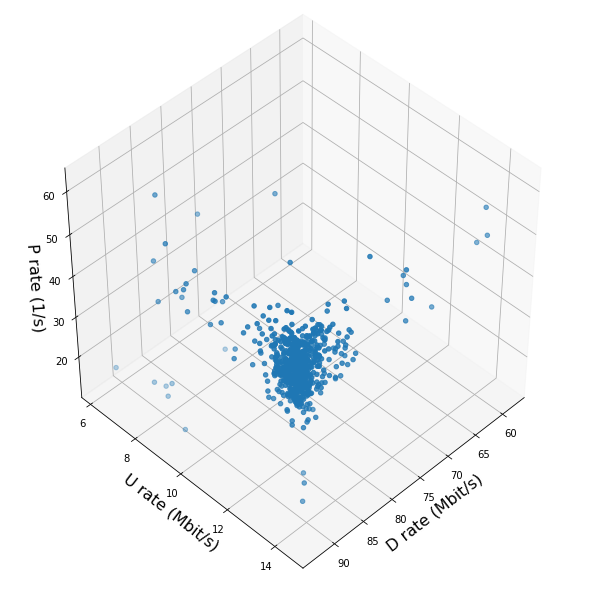

<function __main__.<lambda>(azim, elev)>

In [9]:
# Code Cell 6
# Draw interactive plot
xi = df_rates['download_rate']
yi = df_rates['upload_rate']
zi = df_rates['ping_rate']
interact(lambda azim, elev: scatter_view(xi, yi, zi, azim, elev),
         azim=(0, 90), elev=(0, 90))

### Parte 2: Detección de anomalías euclidiana

**Paso 1: Calcular los promedios**

A través de la función de Pandas correspondiente, calcule la lista de mu, cuyos elementos son las velocidades de descarga, carga y ping promedio.

In [11]:
# Code Cell 7
mu = df_rates.mean()

**Paso 2: Calcular la distancia euclidiana**

Busque la distancia euclidiana entre cada punto y la ubicación promedio. Puede recurrir a las funciones Numpy np.square y np.sqrt. Estas computan la potencia cuadrada y la raíz cuadrada basadas en elementos de cualquier matriz de entrada. El uso de funciones basadas en elementos facilita el cálculo de distancias sin bucles for que se iteran entre los puntos de datos.

In [13]:
# Code Cell 8
euclid_sq = np.square(df_rates - mu).sum(axis=1)
euclid = np.sqrt(euclid_sq)


Paso 3: Crear un histograma

Cree un histograma de la distancia que separa cada punto de datos de la ubicación promedio. Las anomalías luego se reconocen fácilmente en la "cola" del histograma.


Text(0, 0.5, 'Relative frequency')

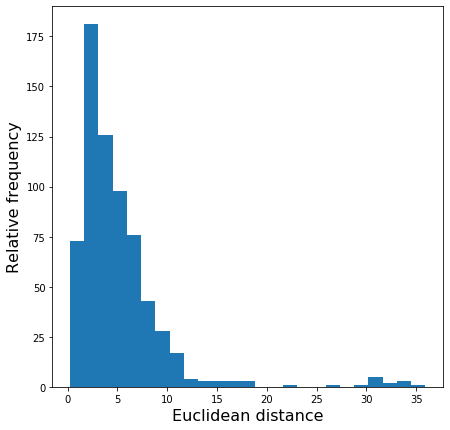

In [14]:


# Code Cell 9
# Histogram of Euclidean distance
fig = plt.figure(figsize=(7, 7))
plt.hist(euclid, 25)
plt.xlabel('Euclidean distance', fontsize=16)
plt.ylabel('Relative frequency', fontsize=16)




**Paso 4: Calcular la distancia normalizada**

Es útil trabajar en términos de distancia normalizada. Esta es la relación de cada distancia sobre el valor máximo de $d$. Los puntos anómalos más alejados tienen, entonces, una distancia normalizada de 1. Calcule la distancia euclidiana normalizada para cada punto del conjunto de datos.


In [15]:
euclid

0      11.708170
1       8.229111
2      30.609053
3       3.391286
4       4.514432
         ...    
667     8.404082
668     2.119151
669     6.333024
670     5.601480
671    10.593640
Length: 672, dtype: float64

In [16]:
# Code Cell 10
max_euclid = euclid.max() # Maximum Euclidean distance
nmd_euclid = [float(x)/max_euclid for x in euclid] # Normalized Euclidean distance




**Paso 5: Visualizar el índice de alarmas**

Para etiquetar puntos como normales o anómalos, debe definir un límite de decisión. Es necesario seleccionar la distancia más allá de qué puntos se consideran anormales. Si bien la posición del límite se puede fijar según consideraciones cualitativas, es preferible un enfoque cuantitativo. Puede aumentar gradualmente la distancia de decisión y monitorear cómo varía el índice de alarma. Específicamente, el índice de alarma es la cantidad de anomalías dividida por la cantidad total de puntos de datos. Este procedimiento prueba todos los límites de decisiones posibles y nos permite seleccionar el más adecuado.

Modifique la distancia de decisión normalizada de 0 a 1 y registre el índice de alarmas en cada paso. Guarde los valores de la distancia normalizada y del índice de alarma en las listas nmd_range y ecl_alarm_rate respectivamente. Para mostrar estos resultados, genere un gráfico.


In [20]:
# Code Cell 11
# Get alarm rate as a function
# of normalized decision distance
ecl_alarm_rate = []
nmd_range = np.linspace(0, 1, 400)
for nmd_decision in nmd_range:
    num_fail = (nmd_euclid>nmd_decision).sum()
    ecl_alarm_rate.append(float(num_fail) / len(euclid))

Text(0, 0.5, 'Alarm rate')

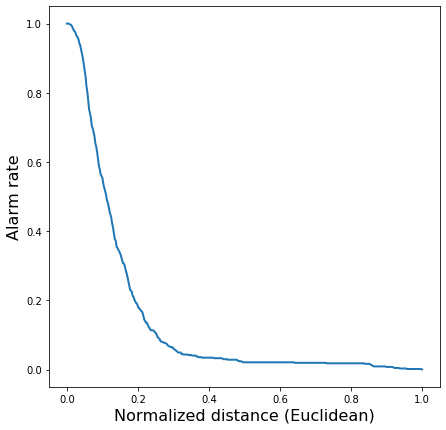

In [21]:
# Code Cell 12
# Generate a suitable plot
fig = plt.figure(figsize=(7, 7))
plt.plot(nmd_range, ecl_alarm_rate, linewidth=2)
plt.xlabel('Normalized distance (Euclidean)', fontsize=16)
plt.ylabel('Alarm rate', fontsize=16)


**Paso 6: Seleccionar el límite de decisión**

El gráfico de arriba convierte el problema de fijar un límite de decisión en el de seleccionar el índice de alarmas. Esto es una ventaja porque el dominio de aplicación, por lo general, determina una elección razonable para el índice de alarmas. Por ejemplo, al probar la seguridad de motores de aviones, tal vez deseemos elegir el índice de alarmas sea relativamente alto, de forma tal que se detecten tanto las anomalías importantes como las leves, y el nivel de riesgo sea mantenga bajo.

Supongamos que, para este caso de uso específico, el índice de alarmas ideal sea 0.1. Busque la distancia de decisión normalizadas más pequeña (ecl_decision) de forma tal que el índice de alarma caiga estrictamente por debajo del umbral. Debido a que el índice de alarmas en el límite de decisión seleccionado no será precisamente 0.1, guarde el índice exacto en la variable ecl_threshold.


In [24]:
# Code Cell 13
# Select decision boundary
threshold = 0.1
index, ecl_threshold = next(tpl for tpl in enumerate(ecl_alarm_rate) if tpl[1]<threshold)
ecl_decision = nmd_range[index]


**Paso 7: Visualizar el límite de decisión**

Genere el diagrama del paso 5 nuevamente utilizando un punto para marcar la ubicación del límite de decisión.


Text(0, 0.5, 'Alarm rate')

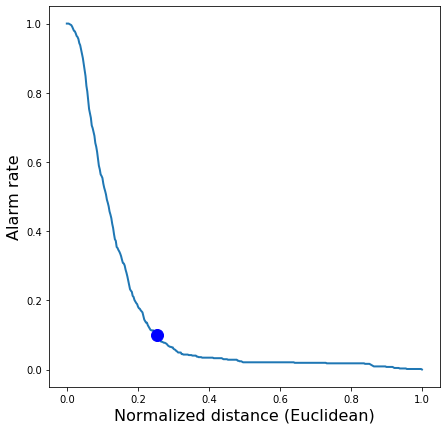

In [25]:
#Code Cell 14
# Alarm rate with decision boundary
fig = plt.figure(figsize=(7, 7))
plt.plot(nmd_range, ecl_alarm_rate, linewidth=2)
plt.plot(ecl_decision,ecl_threshold,'bo',markersize=12)
plt.xlabel('Normalized distance (Euclidean)', fontsize=16)
plt.ylabel('Alarm rate', fontsize=16)


**Paso 8: Visualizar el límite de decisión en 3D**

Debido a que nuestro algoritmo de detección de anomalías utiliza distancias euclidianas, sus límites de decisión, cuando se visualizan en tres dimensiones, son esféricos. Observe el siguiente gráfico para comprobar esto. También le sugerimos leer y comprender el código asociado.


In [26]:
#Code Cell 15
# Decision sphere (Polar coordinates)
radius = ecl_decision * max_euclid
phi = np.linspace(0, 2 * np.pi, 300)
theta = np.linspace(0, np.pi, 300)

# Decision sphere (Cartesian coordinates)
xs = radius * np.outer(np.sin(theta), np.cos(phi))
ys = radius * np.outer(np.sin(theta), np.sin(phi))
zs = radius * np.outer(np.cos(theta), np.ones(np.size(phi)))

# Centre decision sphere at mean
ecl_xd = xs + df_rates['download_rate'].mean()
ecl_yd = ys + df_rates['upload_rate'].mean()
ecl_zd = zs + df_rates['ping_rate'].mean()



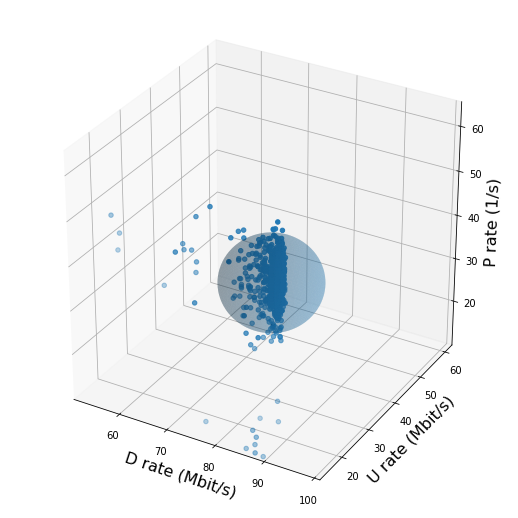

In [27]:
fig = plt.figure(figsize=(7, 7))
ax = Axes3D(fig)

# Plot data
ax.scatter(df_rates['download_rate'],
           df_rates['upload_rate'], 
           df_rates['ping_rate'])

# Plot decision boundary
ax.plot_surface(ecl_xd, ecl_yd, ecl_zd,
                linewidth=0, alpha=0.25)

# Label axes
ax.set_xlabel('D rate (Mbit/s)', fontsize=16)
ax.set_ylabel('U rate (Mbit/s)', fontsize=16)
ax.set_zlabel('P rate (1/s)', fontsize=16)
    
# --------------------------------------------------
# Set equal aspect ratio for all axes
# --------------------------------------------------

# Extreme values of x, y, z
extremes = []
extremes.append([df_rates['download_rate'].min(),
                 df_rates['download_rate'].max()])
extremes.append([df_rates['upload_rate'].min(),
                 df_rates['upload_rate'].max()])
extremes.append([df_rates['ping_rate'].min(),
                 df_rates['ping_rate'].max()])

# Half-widths and mid-points
hwidths = [(row[1] - row[0]) / 2.0 for row in extremes]
midpts = [(row[1] + row[0]) / 2.0 for row in extremes]

# Set xlim, ylim, zlim
left_ends = midpts - np.max(hwidths)
right_ends = midpts + np.max(hwidths)
ax.set_xlim([left_ends[0], right_ends[0]]);
ax.set_ylim([left_ends[1], right_ends[1]]);
ax.set_ylim([left_ends[2], right_ends[2]]);